In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/bensonmanner/Desktop/ACME/WebbResearch/Projects/Optimization/delay-optimizer')
import pandas as pd
from DelayEffects.Analyzer import Analyzer

# Helper Functions

In [3]:
# Initialize
loss_name = 'Ackley'
ackley2d = Analyzer(2, loss_name)
ackley10d = Analyzer(10, loss_name)
ackley100d = Analyzer(100, loss_name)
ackley1000d = Analyzer(1000, loss_name)
ackley10000d = Analyzer(10000, loss_name)

In [4]:
# Helper Functions
def fill_table(analyzer, max_L, num_points, partials=[0.2, 0.5, 0.8], same_points=False):
    # Initialize data array
    data = np.nan*np.zeros((4, 3 + 2*len(partials)))
    
    # Initialize column and index names
    columns = ['No Change', 'On/Off', 'Decaying']
    new_cols = []
    for percent in partials:
        columns.append("Partial ({}%)".format(percent*100))
        new_cols.append("Stochastic Partial ({}%)".format(percent*100))
    columns += new_cols
    indices = ['Constant', 'Periodic', 'Stochastic', 'Undelayed']
    
    # Use the same initial points for all calculations?
    if same_points is True:
        analyzer.initialize_points(num_points, 'random')
        gen_points = False
    
    # Perform the computations
    # Constant
    data[0,0] = test(analyzer, "constant", "same", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[0,1] = test(analyzer, "constant", "binary", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[0,2] = test(analyzer, "constant", "decay", max_L, num_points, print_vals=False, gen_points=gen_points)
    for i, percent in enumerate(partials):
        data[0,3+i] = test(analyzer, "constant", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[0,3+i+len(partials)] = test(analyzer, "constant", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Periodic
    data[1,0] = test(analyzer, "periodic", "same", max_L, num_points, print_vals=False)
    data[1,1] = test(analyzer, "periodic", "binary", max_L, num_points, print_vals=False)
    data[1,2] = test(analyzer, "periodic", "decay", max_L, num_points, print_vals=False)
    for i, percent in enumerate(partials):
        data[1,3+i] = test(analyzer, "periodic", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[1,3+i+len(partials)] = test(analyzer, "periodic", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Stochastic
    data[2,0] = test(analyzer, "stochastic", "same", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[2,1] = test(analyzer, "stochastic", "binary", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[2,2] = test(analyzer, "stochastic", "decay", max_L, num_points, print_vals=False, gen_points=gen_points)
    for i, percent in enumerate(partials):
        data[2,3+i] = test(analyzer, "stochastic", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[2,3+i+len(partials)] = test(analyzer, "stochastic", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Undelayed
    analyzer.calculate_save_values(False, save_grad=False, save_state=False, save_iters=False, break_opt=False)
    data[3,0] = np.mean(analyzer.final_losses)
        
    # Create the dataframe
    dataframe = pd.DataFrame(data, index=indices, columns=columns)
    dataframe.style.set_caption("Rosenbrock Function | n={} | Max Delay is {}".format(analyzer.n, analyzer.max_L))
    
    return dataframe
    
        
def test(analyzer, test_type, dist_type, max_L, num_points, stochastic_partials=False, percent=0.5, 
         print_vals=True, gen_points=True):
    # Initialize
    n = analyzer.n
    maxiter = analyzer.maxiter
    num_delays = 1000   # How many iterations to delay for binary distributions
    random = False
    
    if test_type == 'constant':
        if dist_type == 'same':
            # Delays are all equal to max_L in every dimension for the full number of iterations
            print_str = "No Change Constant"
            D = max_L * np.ones(n, dtype=int)
            D = [D]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays are all equal to max_L in every dimension, but delays are turned off after 1000 iterations
            print_str = "On/Off Constant"
            D = max_L * np.ones(n, dtype=int)
            D = [D]
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays start with max_L in every dimension and decrease over time
            print_str = "Decaying Constant"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                D.append(D_s[i]*np.ones(n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'partial':
            # Delays are all equal to max_L, but only in some of the dimensions (others are undelayed)
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                # Choose which dimensions are delayable stochastically each iteration
                print_str = "{} Stochastic Partial Constant".format(percent)
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    for dim in range(n):
                        if np.random.random() < percent:
                            iter_delay[dim] = max_L
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Constant".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = max_L
                D = [D_s]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
            
    elif test_type == 'periodic':
        if dist_type == 'same':
            # Delays alternate over time between max_L and 0 (no delay) for the full number of iterations
            print_str = "No Change Periodic"
            D = [max_L*np.ones(n, dtype=int), np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays alternate over time between max_L and 0, and delays are turned off after 1000 iterations
            print_str = "On/Off Periodic"
            D = [max_L*np.ones(n, dtype=int), np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays alternate over time between max_L and 0, but max_L decreases over time
            print_str = "Decaying Periodic"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                if i % 2 == 0:
                    D.append(D_s[i]*np.ones(n, dtype=int))
                else:
                    D.append(np.zeros(n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'partial':
            # Delays alternate over time between max_L and 0, but only in some of the dimensions (others are undelayed)
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                print_str = "{} Stochastic Partial Periodic".format(percent)
                # Choose which dimensions are delayable stochastically each iteration
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    if i % 2 == 0:
                        for dim in range(n):
                            if np.random.random() < percent:
                                iter_delay[dim] = max_L
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Periodic".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = max_L
                D = [D_s, np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
            
    elif test_type == 'stochastic':
        if dist_type == 'same':
            # Delays are determined stochastically in every dimension for the full number of iterations
            print_str = "No Change Stochastic"
            D = None
            random = True
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays are determined stochastically in every dimension, and are turned off after 1000 iterations
            print_str = "Binary Stochastic"
            D = None
            random = True
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays are determined stochastically in every dimension, but max_L decreases over time
            print_str = "Decaying Stochastic"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                D.append(np.random.randint(0, D_s[i]+1, size=n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L) 
        elif dist_type == 'partial':
            # Delayed dimensions are done with normal stochastic delays, and others dimensions are undelayed
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                # Choose which dimensions are delayable stochastically each iteration
                print_str = "{} Stochastic Partial Stochastic".format(percent)
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    for dim in range(n):
                        if np.random.random() < percent:
                            iter_delay[dim] = np.random.randint(0, max_L+1)
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Stochastic".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = np.random.randint(0, max_L+1,num_delay_dims)
                D = [D_s]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
    else:
        raise ValueError("{} is not a valid test type".format(test_type))
    
    # Perform the optimization
    if gen_points is True:
        analyzer.initialize_points(num_points, 'random')
    analyzer.calculate_save_values(True, D=D, random=random, save_grad=False, save_state=False, 
                                   save_iters=False, break_opt=False)
    
    if print_vals is True:
        print("{} Delay - Max Delay of {}\nAverage Loss: {}".format(print_str, max_L, np.mean(analyzer.del_final_losses)), 
              end='\n\n')
        
    return np.mean(analyzer.del_final_losses)

## 2 dimensional stochastic delayed test

In [4]:
plots = [(True, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', True, plots, time_plot=False, contour_plot=False, colorbar=True, random=True)

KeyboardInterrupt: 

## 2 dimensional 100% delayed test

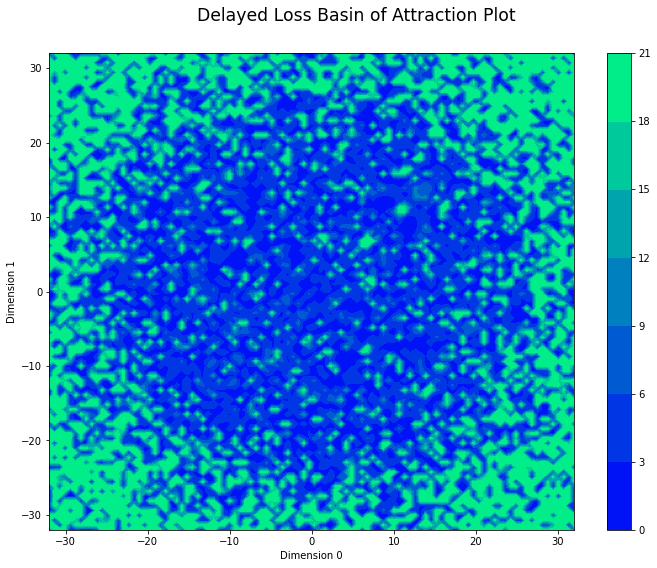

Minimum Delayed Loss: 0.2135743487449493
Mean Delayed Loss: 9.053883600842148
Median Delayed Loss: 4.884065265863555


In [9]:
D_s = np.ones(2,dtype=int)
D = [D_s]
plots = [(True, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', True, plots, time_plot=False, contour_plot=False, colorbar=True, random=False, D=D)

## 2 dimensional 50% delayed test

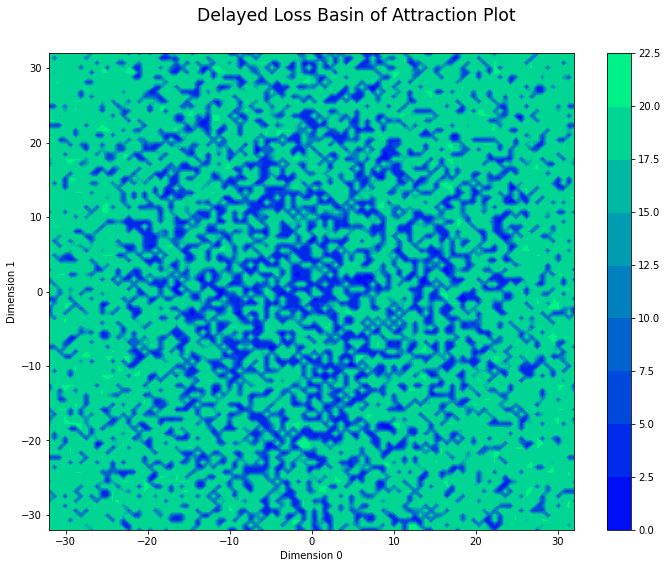

Minimum Delayed Loss: 0.20345719460694456
Mean Delayed Loss: 14.086782877784001
Median Delayed Loss: 19.867373388949634


In [7]:
D_s = np.zeros(2,dtype=int)
D_s[0] = 1
D = [D_s]
plots = [(True, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', True, plots, time_plot=False, contour_plot=False, colorbar=True, random=False, D=D)

## 2 dimensional undelayed test

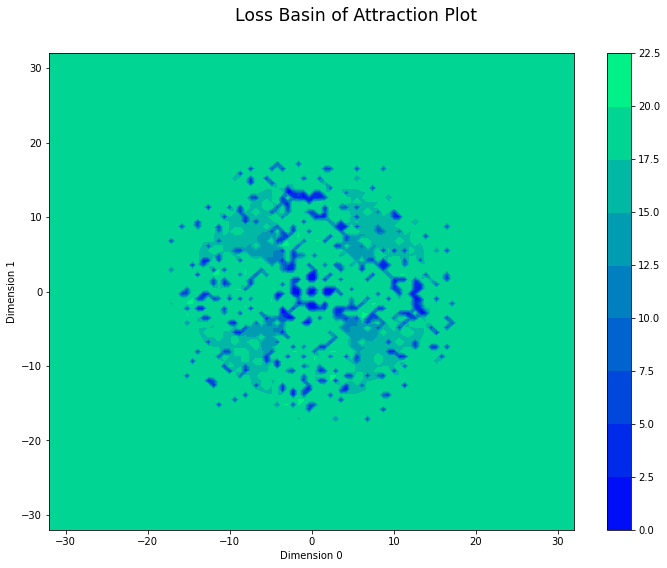

Minimum Loss: 0.16819041018336067
Mean Loss: 18.632774961440457
Median Loss: 19.60685273253687


In [8]:
plots = [(False, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', False, plots, time_plot=False, contour_plot=False, colorbar=True, random=True)

In [15]:
def chaos_test(analyzer, eps=1e-5, max_L=1, num_points=1, given=None, num_delays=1000):
    # Initialize
    n = analyzer.n
    low, high = analyzer.range_grid

    # Set or unpack initial values
    if given is None:
        x_init = np.random.uniform(low, high, size=(1,n))
        x_init_err = x_init + np.random.uniform(-eps,eps,(num_points,n))
        x_inits = np.vstack((x_init, x_init_err))
    else:
        x_inits = given

    print(x_init)
    # Find paths constant
    analyzer.optimize(1, 'given', True, plots=[[True, 'path', 'loss']], points=x_inits, 
                      max_L=max_L, D=[np.ones(n, dtype=int)], random=False, time_plot=True, 
                      clear_data=False, num_delays=num_delays, break_opt=False)

    # Plot the error over time
    fig = plt.figure(figsize=(10,8))
    for i in range(1,num_points):
        x1 = analyzer.del_time_series[0]
        x2 = analyzer.del_time_series[i]
        plt.semilogy(np.linalg.norm(x1 - x2, axis=1), 'C1', alpha=0.25)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.title("Error of closely spaced points over time")
    plt.show()
    
    analyzer.clear()

In [5]:
def plot_convergence(analyzer, num_points, plot_dims=[(0,1)], grid=False, cut=0, delayed=True):
    """Plot the path of points as they converge to the minimum"""
    if grid is True:
        sample = 'grid'
    else:
        sample = 'random'
        
    analyzer.initialize_points(num_points, sample)
    analyzer.calculate_save_values(delayed, break_opt=False)
    # Initialize for the graph
    num_plots = len(plot_dims)
    fig, ax = plt.subplots(num_plots, 1, figsize=(10,8*(num_plots)))
    if type(ax) is not np.ndarray:
        ax = np.array([ax])
    alpha = 0.01
            
    for j in range(num_plots):
        axis = ax[j]
        dim_tuple = plot_dims[j]
        for i in range(len(analyzer.x_inits)):
            data = analyzer.extract_dims(i, dim_tuple, delayed)
            im = axis.scatter(data[0][cut:], data[1][cut:], color='r', alpha=0.1, s=0.1)
        axis.set_xlabel("Dimension {}".format(dim_tuple[0]))
        axis.set_ylabel("Dimension {}".format(dim_tuple[1]))
        axis.set_xlim(analyzer.range_grid)
        axis.set_ylim(analyzer.range_grid)
        
    plt.show()

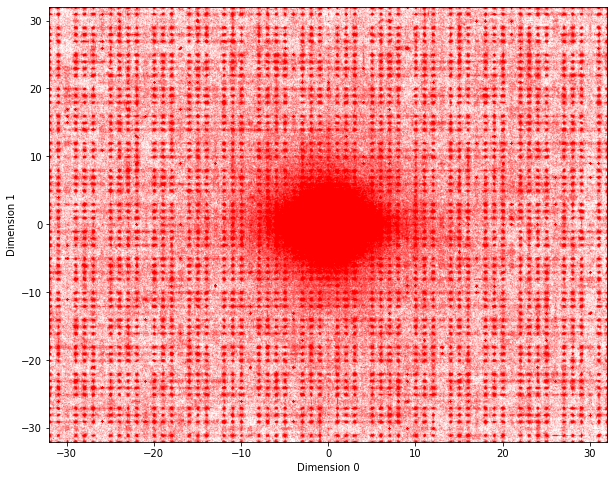

In [10]:
plot_convergence(ackley2d, 50, grid=True, cut=0)

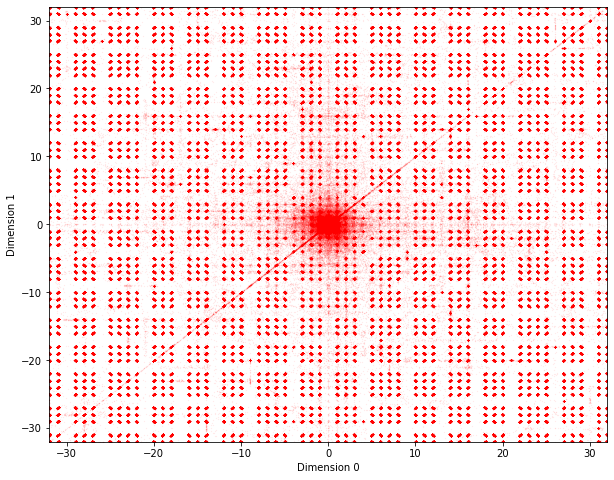

In [9]:
plot_convergence(ackley2d, 50, grid=True, cut=0, delayed=False)

In [ ]:
plot_convergence(ackley10d, 50, grid=True, cut=0)

In [ ]:
plot_convergence(ackley10d, 50, grid=True, cut=0, delayed=False)